# Task 4: Insights and Recommendations Analysis

This notebook runs the Task 4 analysis to identify satisfaction drivers, pain points, and generate recommendations for each bank.


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import numpy as np

# Add scripts directory to path to import our functions
sys.path.append('../scripts/task4_insights')

# Import Task 4 functions
from insights_analysis import (
    calculate_bank_metrics,
    identify_drivers,
    identify_pain_points,
    extract_keywords_from_reviews,
    compare_banks,
    generate_recommendations,
    analyze_all_banks,
    save_insights_to_csv
)

# Create a load_data function that works from notebooks folder
def load_data():
    """Load processed review data with sentiment and themes."""
    df = pd.read_csv('../data/processed/reviews_with_themes.csv')
    df['date'] = pd.to_datetime(df['date'])
    return df

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries and functions imported successfully!")


✅ All libraries and functions imported successfully!


## Step 1: Load Data


In [2]:
# Load the processed review data with sentiment and themes
df = load_data()

print(f"📊 Total Reviews: {len(df)}")
print(f"🏦 Banks: {df['bank'].unique()}")
print(f"\nData Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


📊 Total Reviews: 1200
🏦 Banks: ['CBE' 'BOA' 'Dashen']

Data Shape: (1200, 9)

Columns: ['review_text', 'rating', 'date', 'bank', 'source', 'review_id', 'sentiment_label', 'sentiment_score', 'theme']

First few rows:


,review_text,rating,date,bank,source,review_id,sentiment_label,sentiment_score,theme
0,good,5,2025-11-30,CBE,Google Play,1,POSITIVE,0.999816,Other
1,CBE ይለያል።,5,2025-11-29,CBE,Google Play,2,POSITIVE,0.988648,Other
2,it's special for me,5,2025-11-29,CBE,Google Play,3,POSITIVE,0.999820,Other
3,Make it user friendly.,2,2025-11-28,CBE,Google Play,4,POSITIVE,0.992062,User Interface & Experience
4,maaliif daddafee install gaafata,3,2025-11-28,CBE,Google Play,5,NEGATIVE,0.987553,Transaction Performance


## Step 2: Calculate Metrics for Each Bank


In [3]:
# Calculate metrics for all banks
banks = df['bank'].unique()
metrics_summary = []

for bank in banks:
    metrics, bank_df = calculate_bank_metrics(df, bank)
    metrics_summary.append({
        'Bank': bank,
        'Total Reviews': metrics['total_reviews'],
        'Avg Rating': f"{metrics['avg_rating']:.2f}",
        'Positive %': f"{metrics['positive_sentiment_pct']:.1f}%",
        'Negative %': f"{metrics['negative_sentiment_pct']:.1f}%",
        'Avg Sentiment Score': f"{metrics['avg_sentiment_score']:.3f}"
    })

metrics_df = pd.DataFrame(metrics_summary)
print("📈 Bank Performance Metrics:")
print("=" * 80)
display(metrics_df)


📈 Bank Performance Metrics:


,Bank,Total Reviews,Avg Rating,Positive %,Negative %,Avg Sentiment Score
0,CBE,400,4.13,64.2%,35.2%,0.969
1,BOA,400,3.37,45.8%,53.5%,0.959
2,Dashen,400,4.01,65.5%,34.0%,0.972


## Step 3: Identify Drivers (What Users Like)


In [4]:
# Identify drivers for each bank
print("=" * 80)
print("SATISFACTION DRIVERS - What Makes Users Happy")
print("=" * 80)

all_drivers = {}
for bank in banks:
    _, bank_df = calculate_bank_metrics(df, bank)
    drivers = identify_drivers(bank_df, top_n=3)
    all_drivers[bank] = drivers
    
    print(f"\n🏦 {bank} - Top Drivers:")
    print("-" * 60)
    for i, driver in enumerate(drivers, 1):
        print(f"\n  {i}. {driver['theme']}")
        print(f"     • Mentions: {driver['count']} ({driver['percentage']:.1f}% of positive reviews)")
        print(f"     • Avg Rating: {driver['avg_rating']:.2f}")
        print(f"     • Sample Review: \"{driver['sample_review'][:100]}...\"")

# Create a DataFrame for better visualization
drivers_data = []
for bank, drivers_list in all_drivers.items():
    for driver in drivers_list:
        drivers_data.append({
            'Bank': bank,
            'Theme': driver['theme'],
            'Count': driver['count'],
            'Percentage': f"{driver['percentage']:.1f}%",
            'Avg Rating': f"{driver['avg_rating']:.2f}"
        })

drivers_df = pd.DataFrame(drivers_data)
print("\n\n📊 Drivers Summary Table:")
display(drivers_df)


SATISFACTION DRIVERS - What Makes Users Happy

🏦 CBE - Top Drivers:
------------------------------------------------------------

  1. Other
     • Mentions: 205 (87.2% of positive reviews)
     • Avg Rating: 4.90
     • Sample Review: "good..."

  2. Transaction Performance
     • Mentions: 7 (3.0% of positive reviews)
     • Avg Rating: 4.86
     • Sample Review: "This application is very important and advantage for transfer of money and finance in the coutry and..."

  3. Account Access Issues
     • Mentions: 7 (3.0% of positive reviews)
     • Avg Rating: 4.86
     • Sample Review: "providing very secure service...."

🏦 BOA - Top Drivers:
------------------------------------------------------------

  1. Other
     • Mentions: 143 (87.2% of positive reviews)
     • Avg Rating: 4.94
     • Sample Review: "Very Good..."

  2. Transaction Performance
     • Mentions: 9 (5.5% of positive reviews)
     • Avg Rating: 5.00
     • Sample Review: "fast and simple..."

  3. Customer Support

,Bank,Theme,Count,Percentage,Avg Rating
0,CBE,Other,205,87.2%,4.90
1,CBE,Transaction Performance,7,3.0%,4.86
2,CBE,Account Access Issues,7,3.0%,4.86
3,BOA,Other,143,87.2%,4.94
4,BOA,Transaction Performance,9,5.5%,5.00
5,BOA,Customer Support,7,4.3%,4.86
6,Dashen,Other,185,81.1%,4.89
7,Dashen,Transaction Performance,13,5.7%,4.92
8,Dashen,User Interface & Experience,11,4.8%,4.91


## Step 4: Identify Pain Points (What Users Dislike)


In [5]:
# Identify pain points for each bank
print("=" * 80)
print("PAIN POINTS - What Makes Users Unhappy")
print("=" * 80)

all_pain_points = {}
for bank in banks:
    _, bank_df = calculate_bank_metrics(df, bank)
    pain_points = identify_pain_points(bank_df, top_n=3)
    all_pain_points[bank] = pain_points
    
    print(f"\n🏦 {bank} - Top Pain Points:")
    print("-" * 60)
    for i, pain_point in enumerate(pain_points, 1):
        print(f"\n  {i}. {pain_point['theme']}")
        print(f"     • Complaints: {pain_point['count']} ({pain_point['percentage']:.1f}% of negative reviews)")
        print(f"     • Avg Rating: {pain_point['avg_rating']:.2f}")
        print(f"     • Sample Review: \"{pain_point['sample_review'][:100]}...\"")

# Create a DataFrame for better visualization
pain_points_data = []
for bank, pain_points_list in all_pain_points.items():
    for pain_point in pain_points_list:
        pain_points_data.append({
            'Bank': bank,
            'Theme': pain_point['theme'],
            'Complaints': pain_point['count'],
            'Percentage': f"{pain_point['percentage']:.1f}%",
            'Avg Rating': f"{pain_point['avg_rating']:.2f}"
        })

pain_points_df = pd.DataFrame(pain_points_data)
print("\n\n📊 Pain Points Summary Table:")
display(pain_points_df)


PAIN POINTS - What Makes Users Unhappy

🏦 CBE - Top Pain Points:
------------------------------------------------------------

  1. Other
     • Complaints: 82 (52.9% of negative reviews)
     • Avg Rating: 3.43
     • Sample Review: "this app very bad 👎..."

  2. Transaction Performance
     • Complaints: 24 (15.5% of negative reviews)
     • Avg Rating: 2.25
     • Sample Review: "maaliif daddafee install gaafata..."

  3. Account Access Issues
     • Complaints: 23 (14.8% of negative reviews)
     • Avg Rating: 2.43
     • Sample Review: "why didn't work this app?..."

🏦 BOA - Top Pain Points:
------------------------------------------------------------

  1. Other
     • Complaints: 117 (51.8% of negative reviews)
     • Avg Rating: 2.69
     • Sample Review: "🙏👍..."

  2. Account Access Issues
     • Complaints: 23 (10.2% of negative reviews)
     • Avg Rating: 1.87
     • Sample Review: "when trying to activate the app it keeps on loading on the security questions page. It has be

,Bank,Theme,Complaints,Percentage,Avg Rating
0,CBE,Other,82,52.9%,3.43
1,CBE,Transaction Performance,24,15.5%,2.25
2,CBE,Account Access Issues,23,14.8%,2.43
3,BOA,Other,117,51.8%,2.69
4,BOA,Account Access Issues,23,10.2%,1.87
5,BOA,Transaction Performance,23,10.2%,1.65
6,Dashen,Other,72,47.7%,3.19
7,Dashen,Transaction Performance,22,14.6%,2.41
8,Dashen,Account Access Issues,19,12.6%,2.74


## Step 5: Extract Keywords


In [6]:
# Extract keywords from positive and negative reviews
print("=" * 80)
print("KEYWORD ANALYSIS")
print("=" * 80)

for bank in banks:
    _, bank_df = calculate_bank_metrics(df, bank)
    
    positive_reviews = bank_df[bank_df['sentiment_label'] == 'POSITIVE']['review_text']
    negative_reviews = bank_df[bank_df['sentiment_label'] == 'NEGATIVE']['review_text']
    
    positive_keywords = extract_keywords_from_reviews(positive_reviews)
    negative_keywords = extract_keywords_from_reviews(negative_reviews)
    
    print(f"\n🏦 {bank}:")
    print(f"\n  ✅ Positive Keywords: {positive_keywords}")
    print(f"  ❌ Negative Keywords: {negative_keywords}")


KEYWORD ANALYSIS

🏦 CBE:

  ✅ Positive Keywords: {'ui': 5, 'update': 4, 'transfer': 3, 'feature': 3}
  ❌ Negative Keywords: {'transfer': 30, 'update': 18, 'login': 15, 'feature': 12, 'crash': 6, 'ui': 3, 'security': 3}

🏦 BOA:

  ✅ Positive Keywords: {'ui': 3, 'support': 3, 'feature': 3}
  ❌ Negative Keywords: {'crash': 37, 'transfer': 25, 'update': 22, 'slow': 21, 'ui': 15, 'login': 12, 'feature': 12, 'security': 4}

🏦 Dashen:

  ✅ Positive Keywords: {'ui': 17, 'security': 8, 'transfer': 3, 'feature': 3}
  ❌ Negative Keywords: {'update': 28, 'transfer': 23, 'login': 12, 'ui': 11, 'slow': 10, 'security': 10, 'crash': 9, 'feature': 5, 'support': 3}


## Step 6: Generate Recommendations


In [7]:
# Generate recommendations for each bank
print("=" * 80)
print("RECOMMENDATIONS - Actionable Improvements")
print("=" * 80)

all_recommendations = {}
for bank in banks:
    _, bank_df = calculate_bank_metrics(df, bank)
    drivers = identify_drivers(bank_df, top_n=3)
    pain_points = identify_pain_points(bank_df, top_n=3)
    recommendations = generate_recommendations(drivers, pain_points, bank)
    all_recommendations[bank] = recommendations
    
    print(f"\n🏦 {bank} - Recommendations:")
    print("-" * 60)
    for i, rec in enumerate(recommendations, 1):
        print(f"\n  {i}. [{rec['priority']} Priority] {rec['category']}")
        print(f"     Recommendation: {rec['recommendation']}")
        print(f"     Rationale: {rec['rationale']}")

# Create a DataFrame for recommendations
recs_data = []
for bank, recs_list in all_recommendations.items():
    for rec in recs_list:
        recs_data.append({
            'Bank': bank,
            'Priority': rec['priority'],
            'Category': rec['category'],
            'Recommendation': rec['recommendation'],
            'Rationale': rec['rationale']
        })

recommendations_df = pd.DataFrame(recs_data)
print("\n\n📊 Recommendations Summary Table:")
display(recommendations_df)


RECOMMENDATIONS - Actionable Improvements

🏦 CBE - Recommendations:
------------------------------------------------------------

  1. [High Priority] Performance
     Recommendation: Optimize transaction processing speed and reduce loading times. Implement offline transaction queuing for poor connectivity.
     Rationale: 24 reviews (15.5%) complain about slow transactions.

🏦 BOA - Recommendations:
------------------------------------------------------------

  1. [High Priority] Account Access
     Recommendation: Implement biometric authentication (fingerprint/face ID) and improve PIN recovery process. Add remote verification options for users abroad.
     Rationale: 23 reviews (10.2%) mention account access problems.

🏦 Dashen - Recommendations:
------------------------------------------------------------

  1. [High Priority] Performance
     Recommendation: Optimize transaction processing speed and reduce loading times. Implement offline transaction queuing for poor connectivity

,Bank,Priority,Category,Recommendation,Rationale
0,CBE,High,Performance,Optimize transaction processing speed and redu...,24 reviews (15.5%) complain about slow transac...
1,BOA,High,Account Access,Implement biometric authentication (fingerprin...,23 reviews (10.2%) mention account access prob...
2,Dashen,High,Performance,Optimize transaction processing speed and redu...,22 reviews (14.6%) complain about slow transac...


## Step 7: Visualize Drivers vs Pain Points


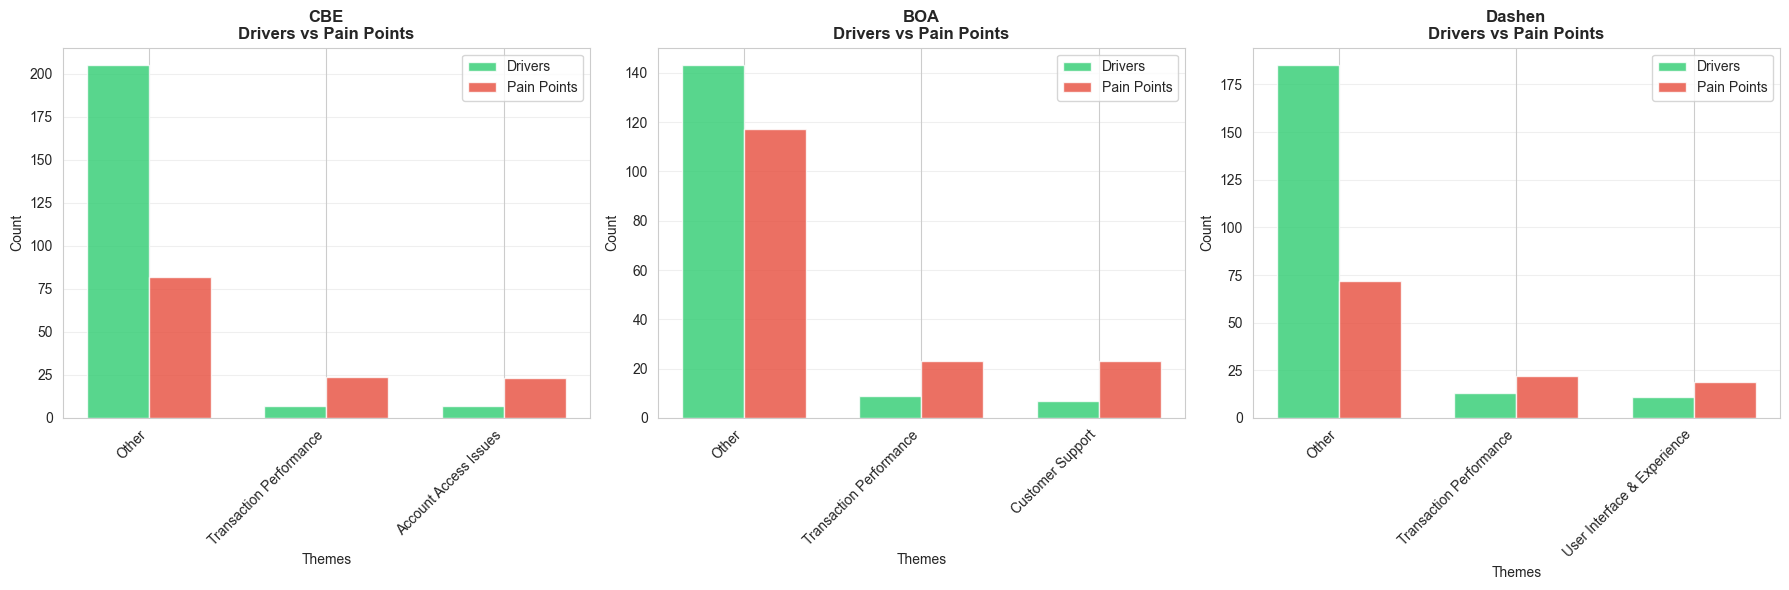

In [8]:
# Create visualization comparing drivers and pain points
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, bank in enumerate(banks):
    _, bank_df = calculate_bank_metrics(df, bank)
    drivers = identify_drivers(bank_df, top_n=3)
    pain_points = identify_pain_points(bank_df, top_n=3)
    
    # Prepare data for plotting
    driver_themes = [d['theme'] for d in drivers]
    driver_counts = [d['count'] for d in drivers]
    
    pain_themes = [p['theme'] for p in pain_points]
    pain_counts = [p['count'] for p in pain_points]
    
    # Create grouped bar chart
    x = np.arange(max(len(driver_themes), len(pain_themes)))
    width = 0.35
    
    # Plot drivers (positive)
    axes[idx].bar(x[:len(driver_counts)] - width/2, driver_counts, width, 
                  label='Drivers', color='#2ecc71', alpha=0.8)
    
    # Plot pain points (negative)
    axes[idx].bar(x[:len(pain_counts)] + width/2, pain_counts, width, 
                  label='Pain Points', color='#e74c3c', alpha=0.8)
    
    axes[idx].set_xlabel('Themes', fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].set_title(f'{bank}\nDrivers vs Pain Points', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x[:max(len(driver_themes), len(pain_themes))])
    axes[idx].set_xticklabels(driver_themes + pain_themes[:max(0, len(pain_themes)-len(driver_themes))], 
                              rotation=45, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Step 8: Run Complete Analysis


In [9]:
# Run the complete analysis (same as running the .py script)
print("Running comprehensive analysis for all banks...")
print("=" * 80)

results = analyze_all_banks(df)

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)


Running comprehensive analysis for all banks...

Analyzing CBE

Metrics:
  Average Rating: 4.13
  Positive Sentiment: 64.2%
  Negative Sentiment: 35.2%

Top Drivers:
  1. Other (205 mentions, 87.2%)
  2. Transaction Performance (7 mentions, 3.0%)
  3. Account Access Issues (7 mentions, 3.0%)

Top Pain Points:
  1. Other (82 mentions, 52.9%)
  2. Transaction Performance (24 mentions, 15.5%)
  3. Account Access Issues (23 mentions, 14.8%)

Analyzing BOA

Metrics:
  Average Rating: 3.37
  Positive Sentiment: 45.8%
  Negative Sentiment: 53.5%

Top Drivers:
  1. Other (143 mentions, 87.2%)
  2. Transaction Performance (9 mentions, 5.5%)
  3. Customer Support (7 mentions, 4.3%)

Top Pain Points:
  1. Other (117 mentions, 51.8%)
  2. Account Access Issues (23 mentions, 10.2%)
  3. Transaction Performance (23 mentions, 10.2%)

Analyzing Dashen

Metrics:
  Average Rating: 4.01
  Positive Sentiment: 65.5%
  Negative Sentiment: 34.0%

Top Drivers:
  1. Other (185 mentions, 81.1%)
  2. Transaction

## Step 9: View Detailed Results


In [10]:
# Display detailed results for each bank
for bank, data in results.items():
    print(f"\n{'='*80}")
    print(f"📊 DETAILED RESULTS FOR {bank}")
    print(f"{'='*80}")
    
    print(f"\n📈 Metrics:")
    metrics = data['metrics']
    print(f"  • Total Reviews: {metrics['total_reviews']}")
    print(f"  • Average Rating: {metrics['avg_rating']:.2f}")
    print(f"  • Positive Sentiment: {metrics['positive_sentiment_pct']:.1f}%")
    print(f"  • Negative Sentiment: {metrics['negative_sentiment_pct']:.1f}%")
    
    print(f"\n✅ Top Drivers:")
    for i, driver in enumerate(data['drivers'], 1):
        print(f"  {i}. {driver['theme']}: {driver['count']} mentions ({driver['percentage']:.1f}%)")
    
    print(f"\n❌ Top Pain Points:")
    for i, pain_point in enumerate(data['pain_points'], 1):
        print(f"  {i}. {pain_point['theme']}: {pain_point['count']} complaints ({pain_point['percentage']:.1f}%)")
    
    print(f"\n💡 Recommendations: {len(data['recommendations'])} generated")
    for i, rec in enumerate(data['recommendations'], 1):
        print(f"  {i}. [{rec['priority']}] {rec['category']}: {rec['recommendation'][:80]}...")



📊 DETAILED RESULTS FOR CBE

📈 Metrics:
  • Total Reviews: 400
  • Average Rating: 4.13
  • Positive Sentiment: 64.2%
  • Negative Sentiment: 35.2%

✅ Top Drivers:
  1. Other: 205 mentions (87.2%)
  2. Transaction Performance: 7 mentions (3.0%)
  3. Account Access Issues: 7 mentions (3.0%)

❌ Top Pain Points:
  1. Other: 82 complaints (52.9%)
  2. Transaction Performance: 24 complaints (15.5%)
  3. Account Access Issues: 23 complaints (14.8%)

💡 Recommendations: 1 generated
  1. [High] Performance: Optimize transaction processing speed and reduce loading times. Implement offlin...

📊 DETAILED RESULTS FOR BOA

📈 Metrics:
  • Total Reviews: 400
  • Average Rating: 3.37
  • Positive Sentiment: 45.8%
  • Negative Sentiment: 53.5%

✅ Top Drivers:
  1. Other: 143 mentions (87.2%)
  2. Transaction Performance: 9 mentions (5.5%)
  3. Customer Support: 7 mentions (4.3%)

❌ Top Pain Points:
  1. Other: 117 complaints (51.8%)
  2. Account Access Issues: 23 complaints (10.2%)
  3. Transaction Perf

## Step 10: Save Insights to CSV


In [11]:
# Save insights to CSV (with corrected path)
insights_data = []
for bank, data in results.items():
    # Drivers
    for driver in data['drivers']:
        insights_data.append({
            'bank': bank,
            'type': 'Driver',
            'theme': driver['theme'],
            'count': driver['count'],
            'percentage': driver['percentage'],
            'avg_rating': driver['avg_rating'],
            'sample_review': driver['sample_review']
        })
    
    # Pain points
    for pain_point in data['pain_points']:
        insights_data.append({
            'bank': bank,
            'type': 'Pain Point',
            'theme': pain_point['theme'],
            'count': pain_point['count'],
            'percentage': pain_point['percentage'],
            'avg_rating': pain_point['avg_rating'],
            'sample_review': pain_point['sample_review']
        })

insights_df = pd.DataFrame(insights_data)
insights_df.to_csv('../data/processed/bank_insights.csv', index=False)

print(f"\n✅ Insights saved successfully to ../data/processed/bank_insights.csv")
print(f"\n📄 Preview of saved insights:")
display(insights_df.head(10))



✅ Insights saved successfully to ../data/processed/bank_insights.csv

📄 Preview of saved insights:


,bank,type,theme,count,percentage,avg_rating,sample_review
0,CBE,Driver,Other,205,87.234043,4.902439,good
1,CBE,Driver,Transaction Performance,7,2.978723,4.857143,This application is very important and advanta...
2,CBE,Driver,Account Access Issues,7,2.978723,4.857143,providing very secure service.
3,CBE,Pain Point,Other,82,52.903226,3.426829,this app very bad 👎
4,CBE,Pain Point,Transaction Performance,24,15.483871,2.250000,maaliif daddafee install gaafata
5,CBE,Pain Point,Account Access Issues,23,14.838710,2.434783,why didn't work this app?
6,BOA,Driver,Other,143,87.195122,4.937063,Very Good
7,BOA,Driver,Transaction Performance,9,5.487805,5.000000,fast and simple
8,BOA,Driver,Customer Support,7,4.268293,4.857143,good service
9,BOA,Pain Point,Other,117,51.769912,2.692308,🙏👍


## Step 11: Ethics and Review Bias Considerations

It's important to acknowledge potential biases in review data when interpreting results.


In [12]:
# Analyze potential biases in the review data
print("=" * 80)
print("ETHICS & REVIEW BIAS ANALYSIS")
print("=" * 80)

# 1. Negative Bias Analysis
print("\n1️⃣ NEGATIVE BIAS:")
print("-" * 60)
total_reviews = len(df)
positive_count = (df['sentiment_label'] == 'POSITIVE').sum()
negative_count = (df['sentiment_label'] == 'NEGATIVE').sum()
positive_pct = (positive_count / total_reviews) * 100
negative_pct = (negative_count / total_reviews) * 100

print(f"   • Positive Reviews: {positive_count} ({positive_pct:.1f}%)")
print(f"   • Negative Reviews: {negative_count} ({negative_pct:.1f}%)")
print(f"   • Observation: Users with negative experiences are more likely to leave reviews")
print(f"   • Impact: May overrepresent problems compared to overall user satisfaction")

# 2. Rating Distribution Analysis
print("\n2️⃣ RATING DISTRIBUTION BIAS:")
print("-" * 60)
rating_dist = df['rating'].value_counts().sort_index()
print("   Rating Distribution:")
for rating, count in rating_dist.items():
    pct = (count / total_reviews) * 100
    print(f"   • {int(rating)} stars: {count} ({pct:.1f}%)")

low_ratings = (df['rating'] <= 2).sum()
high_ratings = (df['rating'] >= 4).sum()
print(f"\n   • Low Ratings (1-2 stars): {low_ratings} ({(low_ratings/total_reviews)*100:.1f}%)")
print(f"   • High Ratings (4-5 stars): {high_ratings} ({(high_ratings/total_reviews)*100:.1f}%)")
print(f"   • Observation: {'Negative skew detected' if low_ratings > high_ratings else 'Positive skew detected'}")

# 3. Language Bias
print("\n3️⃣ LANGUAGE BIAS:")
print("-" * 60)
# Check for non-English reviews (simple check)
non_english_keywords = ['አ', 'የ', 'በ', 'ለ', 'እንደ']  # Amharic characters
has_non_english = df['review_text'].str.contains('|'.join(non_english_keywords), na=False).sum()
print(f"   • Reviews with Amharic characters: {has_non_english} ({(has_non_english/total_reviews)*100:.1f}%)")
print(f"   • Observation: English reviews may not represent all user segments")
print(f"   • Impact: May miss feedback from users who prefer local languages")

# 4. Recency Bias
print("\n4️⃣ RECENCY BIAS:")
print("-" * 60)
df['date'] = pd.to_datetime(df['date'])
recent_reviews = df[df['date'] >= df['date'].max() - pd.Timedelta(days=30)]
recent_negative = (recent_reviews['sentiment_label'] == 'NEGATIVE').sum()
recent_total = len(recent_reviews)
print(f"   • Reviews in last 30 days: {recent_total} ({(recent_total/total_reviews)*100:.1f}%)")
print(f"   • Negative reviews in last 30 days: {recent_negative} ({(recent_negative/recent_total)*100:.1f}% of recent)")
print(f"   • Observation: Recent issues may be overrepresented")
print(f"   • Impact: Temporary problems may appear more significant than they are")

# 5. Platform Bias
print("\n5️⃣ PLATFORM BIAS:")
print("-" * 60)
# Note: We don't have platform data, but this is a consideration
print(f"   • Observation: Android vs iOS differences may affect ratings")
print(f"   • Impact: Platform-specific issues may not be captured")
print(f"   • Mitigation: Analysis focuses on themes rather than platform-specific issues")

# Mitigation Strategies
print("\n" + "=" * 80)
print("MITIGATION STRATEGIES:")
print("=" * 80)
print("""
✅ Quantitative Analysis: Using both ratings and sentiment scores provides balanced view
✅ Qualitative Analysis: Thematic analysis captures context beyond simple ratings
✅ Time-based Analysis: Trends over time help identify persistent vs temporary issues
✅ Multiple Metrics: Combining sentiment, themes, and ratings reduces single-metric bias
✅ Sample Size: 1,200 reviews (400 per bank) provides reasonable statistical power
✅ Cross-validation: Comparing multiple banks helps identify universal vs bank-specific issues
""")

print("\n⚠️  IMPORTANT CONSIDERATIONS:")
print("""
• Results should be interpreted as indicators, not absolute truths
• Negative bias means problems may be more visible than successes
• Recommendations should prioritize persistent themes over isolated complaints
• Consider conducting user surveys to complement review analysis
• Monitor trends over time rather than relying on snapshot data
""")


ETHICS & REVIEW BIAS ANALYSIS

1️⃣ NEGATIVE BIAS:
------------------------------------------------------------
   • Positive Reviews: 702 (58.5%)
   • Negative Reviews: 491 (40.9%)
   • Observation: Users with negative experiences are more likely to leave reviews
   • Impact: May overrepresent problems compared to overall user satisfaction

2️⃣ RATING DISTRIBUTION BIAS:
------------------------------------------------------------
   Rating Distribution:
   • 1 stars: 253 (21.1%)
   • 2 stars: 44 (3.7%)
   • 3 stars: 76 (6.3%)
   • 4 stars: 100 (8.3%)
   • 5 stars: 727 (60.6%)

   • Low Ratings (1-2 stars): 297 (24.8%)
   • High Ratings (4-5 stars): 827 (68.9%)
   • Observation: Positive skew detected

3️⃣ LANGUAGE BIAS:
------------------------------------------------------------
   • Reviews with Amharic characters: 42 (3.5%)
   • Observation: English reviews may not represent all user segments
   • Impact: May miss feedback from users who prefer local languages

4️⃣ RECENCY BIAS:
---

## Summary

This notebook demonstrates:
- ✅ How to identify satisfaction drivers (what users like)
- ✅ How to identify pain points (what users dislike)
- ✅ How to extract keywords from reviews
- ✅ How to generate actionable recommendations
- ✅ How to visualize and compare results across banks
- ✅ How to consider ethics and review biases in analysis

All results are saved to `data/processed/bank_insights.csv` for further analysis and reporting.

**Note:** Always consider potential biases (negative skew, recency bias, language bias) when interpreting review data and making recommendations.
